In [41]:
# Create a Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("CreditRiskAnalysis") \
    .config("spark.executor.memory", "1g") \
    .config("spark.driver.memory", "1g") \
    .getOrCreate()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import median
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

In [42]:
# Load the CSV file into a DataFrame
data = spark.read.csv("credit_default_dataset.csv", header=True, inferSchema=True)

In [5]:
data.show(5)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default_payment_next_month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|  

In [6]:
data.toPandas().head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
data.count()

30000

In [8]:
data.describe().toPandas()

,summary,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,count,30000,30000,30000,30000,30000,30000,30000,30000,30000,...,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000
1,mean,15000.5,167484.32266666667,1.6037333333333332,1.8531333333333333,1.5518666666666667,35.4855,-0.0167,-0.13376666666666667,-0.1662,...,43262.94896666666,40311.40096666667,38871.7604,5663.5805,5921.1635,5225.6815,4826.076866666666,4799.387633333334,5215.502566666667,0.2212
2,stddev,8660.398374208891,129747.66156720246,0.4891291960902602,0.7903486597207269,0.5219696006132467,9.217904068090155,1.1238015279973335,1.1971859730345495,1.1968675684465686,...,64332.856133916444,60797.15577026471,59554.1075367459,16563.28035402577,23040.870402057186,17606.96146980311,15666.159744032062,15278.305679144742,17777.46577543531,0.41506180569093254
3,min,1,10000,1,0,0,21,-2,-2,-2,...,-170000,-81334,-339603,0,0,0,0,0,0,0
4,max,30000,1000000,2,6,3,79,8,8,8,...,891586,927171,961664,873552,1684259,896040,621000,426529,528666,1


In [9]:
data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: integer (nullable = true)
 |-- BILL_AMT2: integer (nullable = true)
 |-- BILL_AMT3: integer (nullable = true)
 |-- BILL_AMT4: integer (nullable = true)
 |-- BILL_AMT5: integer (nullable = true)
 |-- BILL_AMT6: integer (nullable = true)
 |-- PAY_AMT1: integer (nullable = true)
 |-- PAY_AMT2: integer (nullable = true)
 |-- PAY_AMT3: integer (nullable = true)
 |-- PAY_AMT4: integer (nullable = true)
 |-- PAY_AMT5: integer (nullable = true)
 |-- PAY_AMT6: integer (nullable = true)
 |-- default_payment_next_month: inte

In [10]:
# Check for null values in the DataFrame
null_counts = data.agg(*[F.sum(F.col(c).isNull().cast("int")).alias(c) for c in data.columns])

# Display the null counts
null_counts.show()


+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default_payment_next_month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  0|        0|  0|        0|       0|  0|    0|    0|    0|    0|    0|    0|        0|        0|        0|        0|        0|        0|       0|       0|       0|       0|       0|       0|                         0|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+--

In [11]:
# Columns to check for value == 0

columns_to_check = ["ID", "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE"]

# Create a dictionary to store column names and their corresponding counts
zero_counts = {}

# Iterate through columns and count the number of values equal to 0
for column in columns_to_check:
    count = data.filter(col(column) == 0).count()
    zero_counts[column] = count

# Displays the results
for column, count in zero_counts.items():
    print(f"Column '{column}': {count} values equal to 0")



Column 'ID': 0 values equal to 0
Column 'LIMIT_BAL': 0 values equal to 0
Column 'SEX': 0 values equal to 0
Column 'EDUCATION': 14 values equal to 0
Column 'MARRIAGE': 54 values equal to 0
Column 'AGE': 0 values equal to 0


As there are very few records with values == 0 in columns "EDUCATION" & "MARRIAGE", lets drop them.

In [12]:
# Dropping the rows with values == 0 from the above sepcified columns

columns_to_check = ["ID", "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE"]

# Filter rows where any of the specified columns have values equal to 0
data_filtered = data.filter(
    (col("ID") != 0) &
    (col("LIMIT_BAL") != 0) &
    (col("SEX") != 0) &
    (col("EDUCATION") != 0) &
    (col("MARRIAGE") != 0) &
    (col("AGE") != 0)
)

# Shows the results
data_filtered.show()


+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default_payment_next_month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|  

In [13]:
# Count the number of rows before and after filtering
total_rows_before = data.count()
total_rows_after = data_filtered.count()

# Display the counts
print(f"Total rows before filtering: {total_rows_before}")
print(f"Total rows after filtering: {total_rows_after}")

Total rows before filtering: 30000
Total rows after filtering: 29932


Data Cleaning

In [14]:
data_filtered = data_filtered.drop("ID")
data_filtered = data_filtered.withColumnRenamed("PAY_0", "PAY_1")
data_filtered.limit(10).toPandas()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,100000,2,2,2,23,0,-1,-1,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,140000,2,3,1,28,0,0,2,0,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,20000,1,3,2,35,-2,-2,-2,-2,-1,...,0,13007,13912,0,0,0,13007,1122,0,0


#### EDA

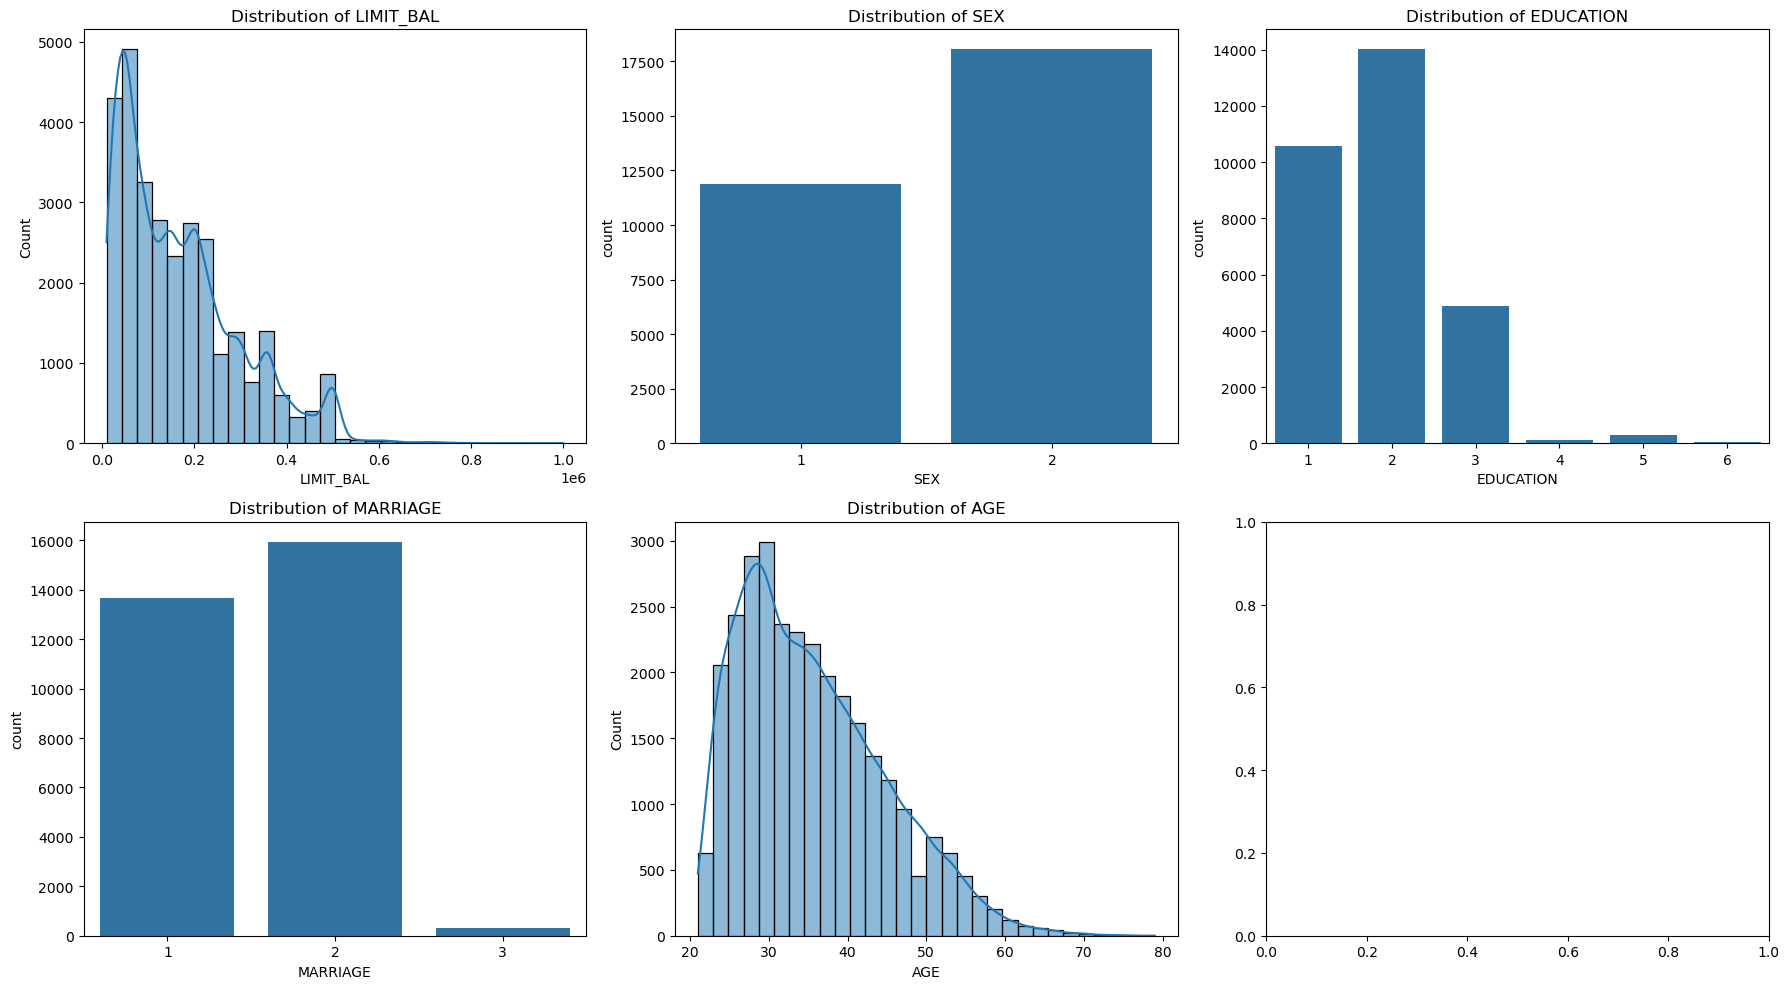

In [15]:


# Set up a 2x3 grid for subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Plot the distribution of LIMIT_BAL
sns.histplot(data_filtered.toPandas()["LIMIT_BAL"], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribution of LIMIT_BAL")

# Plot the distribution of SEX
sns.countplot(x="SEX", data=data_filtered.toPandas(), ax=axes[0, 1])
axes[0, 1].set_title("Distribution of SEX")

# Plot the distribution of EDUCATION
sns.countplot(x="EDUCATION", data=data_filtered.toPandas(), ax=axes[0, 2])
axes[0, 2].set_title("Distribution of EDUCATION")

# Plot the distribution of MARRIAGE
sns.countplot(x="MARRIAGE", data=data_filtered.toPandas(), ax=axes[1, 0])
axes[1, 0].set_title("Distribution of MARRIAGE")

# Plot the distribution of AGE
sns.histplot(data_filtered.toPandas()["AGE"], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Distribution of AGE")

# Adjust layout
plt.tight_layout()
plt.show()


From the above plots, we observed that 
- More number of clients having limiting balance between 0 to 200000
- More number of clients from age bracket of 20 to 40, i.e., clients from mostly young to mid aged groups.
- In EDUCATION, there are multiple categories like others & unknown which doesn't make sense using them as is. Let's group them others.



In [16]:
from pyspark.sql.functions import when

# Create a new column "EDUCATION_grouped"
data_grouped = data_filtered.withColumn(
    "EDUCATION_grouped",
    when((col("EDUCATION") == 4) | (col("EDUCATION") == 5) | (col("EDUCATION") == 6), 4)
    .otherwise(col("EDUCATION"))
)

# Display the unique values in the new grouped column
data_grouped.select("EDUCATION", "EDUCATION_grouped").distinct().show()


+---------+-----------------+
|EDUCATION|EDUCATION_grouped|
+---------+-----------------+
|        2|                2|
|        1|                1|
|        5|                4|
|        3|                3|
|        4|                4|
|        6|                4|
+---------+-----------------+



Now lets, observe the relation of these variables with our target variable "default_payment_next_month".

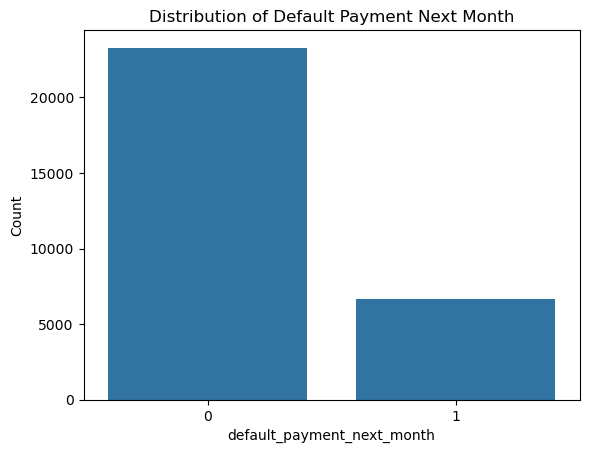

In [17]:
# Plot the distribution of the Target variable
sns.countplot(x="default_payment_next_month", data=data_grouped.toPandas())
plt.title("Distribution of Default Payment Next Month")
plt.xlabel("default_payment_next_month")
plt.ylabel("Count")
plt.show()

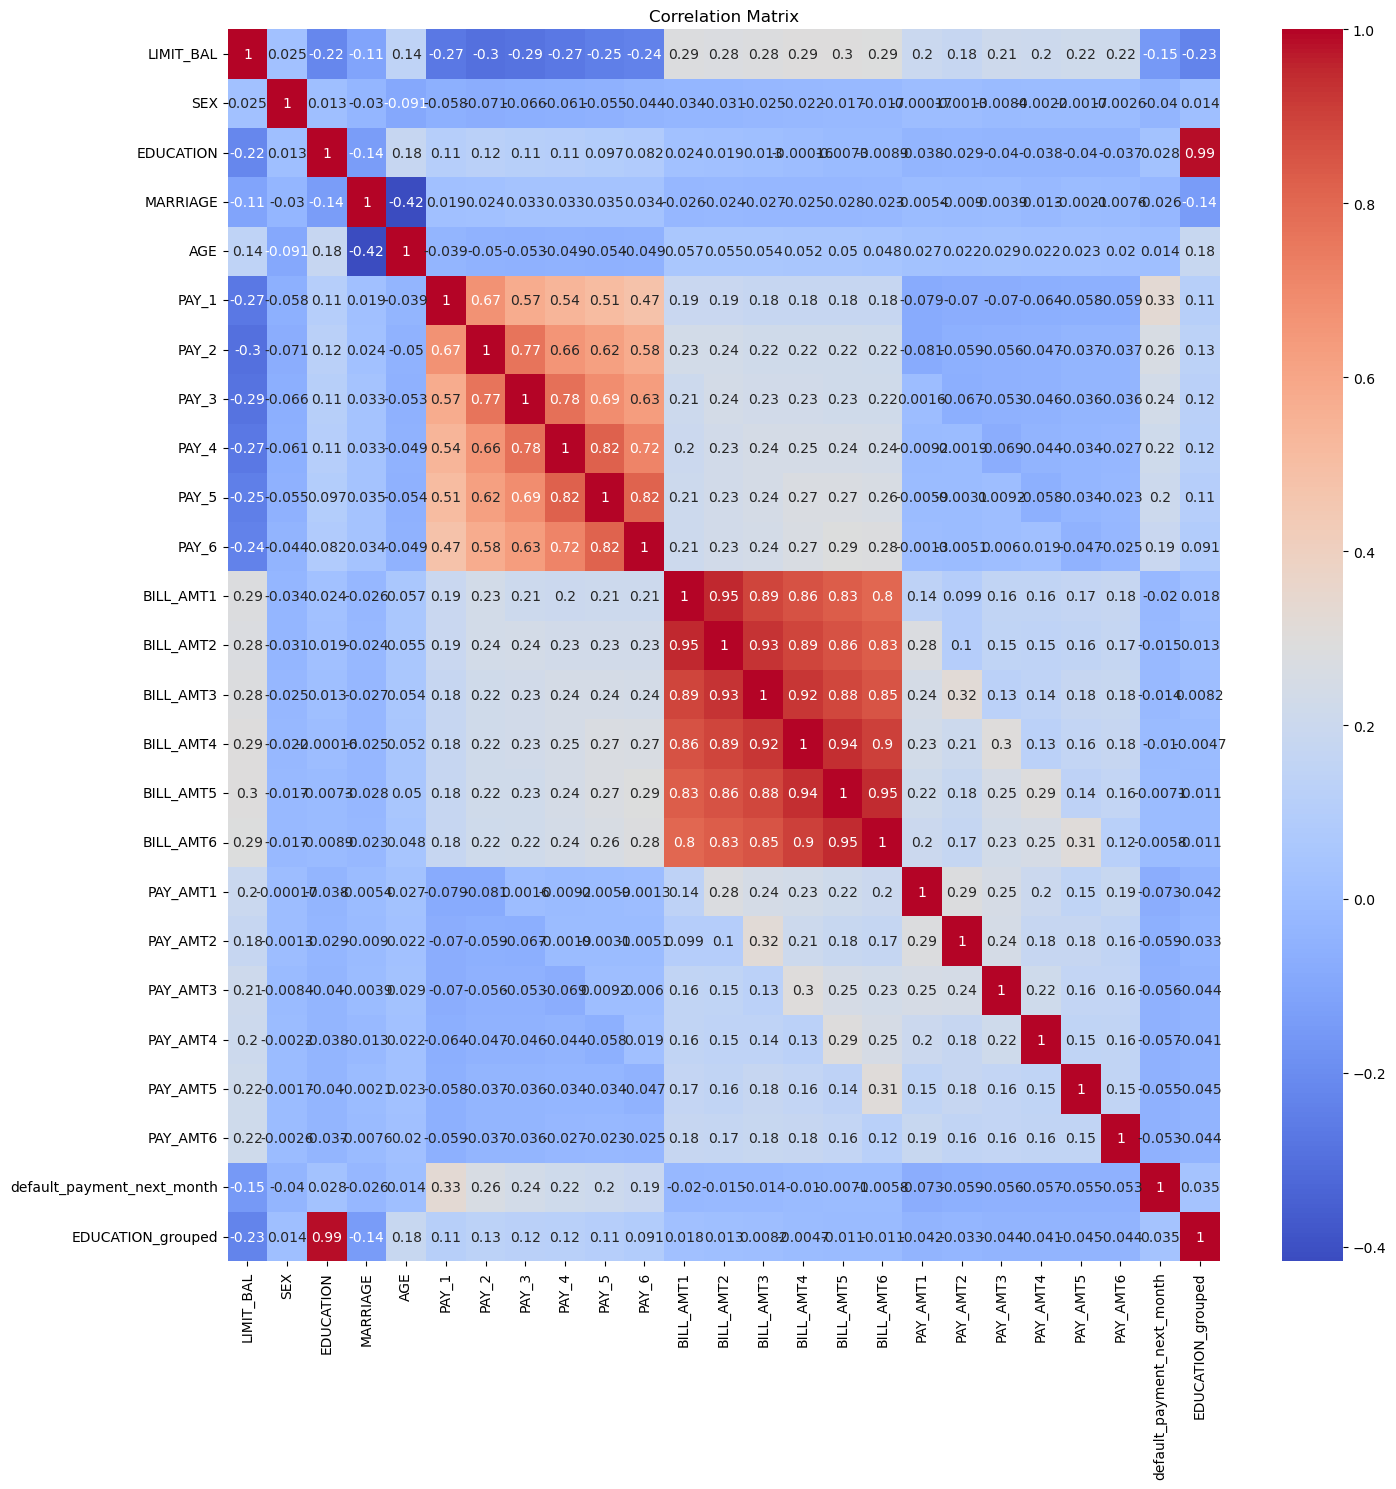

In [18]:
# Correlation matrix
corr_matrix = data_grouped.toPandas().corr()

# Set a larger size for the plot
plt.figure(figsize=(16, 16))

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

# Set the title
plt.title("Correlation Matrix")

# Show the plot
plt.show()


Now lets understand the relation of Target variable with other variables

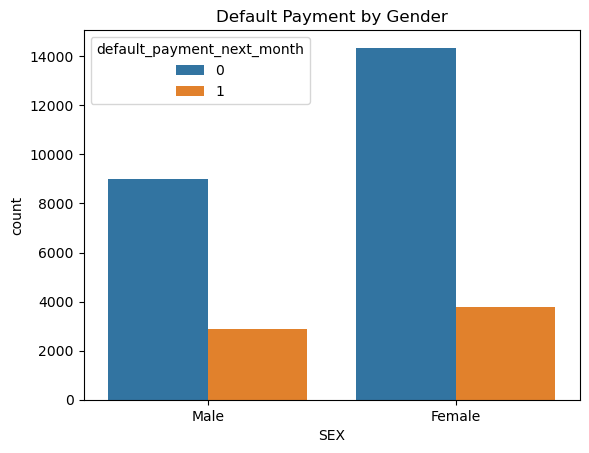

In [19]:

default_by_gender = data.groupBy('SEX', 'default_payment_next_month').count().toPandas()
default_by_gender['SEX'] = default_by_gender['SEX'].replace({1: 'Male', 2: 'Female'})

sns.barplot(x='SEX', y='count', hue='default_payment_next_month', data=default_by_gender)
plt.title('Default Payment by Gender')
plt.show()

Here we observed that, female category have high tendency to default the payments comapred to male cateogry.

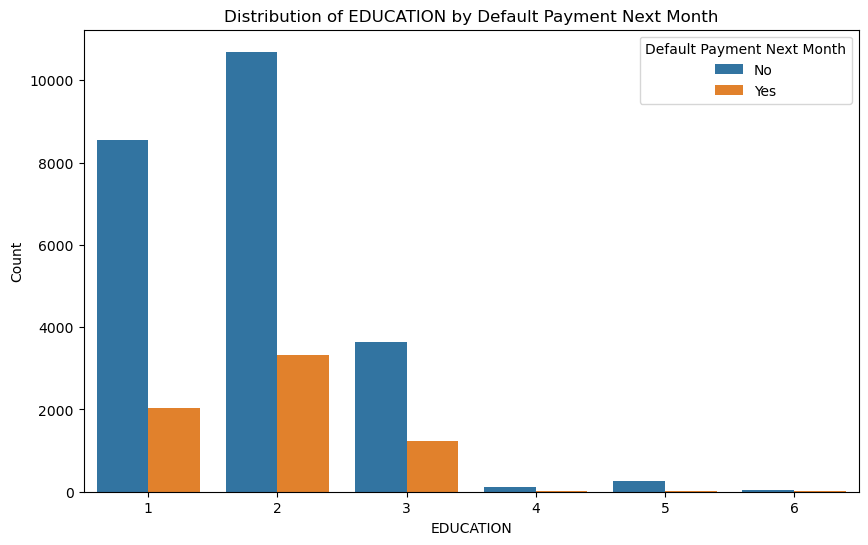

In [20]:

# Count plot for "EDUCATION" by target variable
plt.figure(figsize=(10, 6))
sns.countplot(x="EDUCATION", hue="default_payment_next_month", data=data_grouped.toPandas())
plt.title("Distribution of EDUCATION by Default Payment Next Month")
plt.xlabel("EDUCATION")
plt.ylabel("Count")
plt.legend(title="Default Payment Next Month", labels=["No", "Yes"])
plt.show()


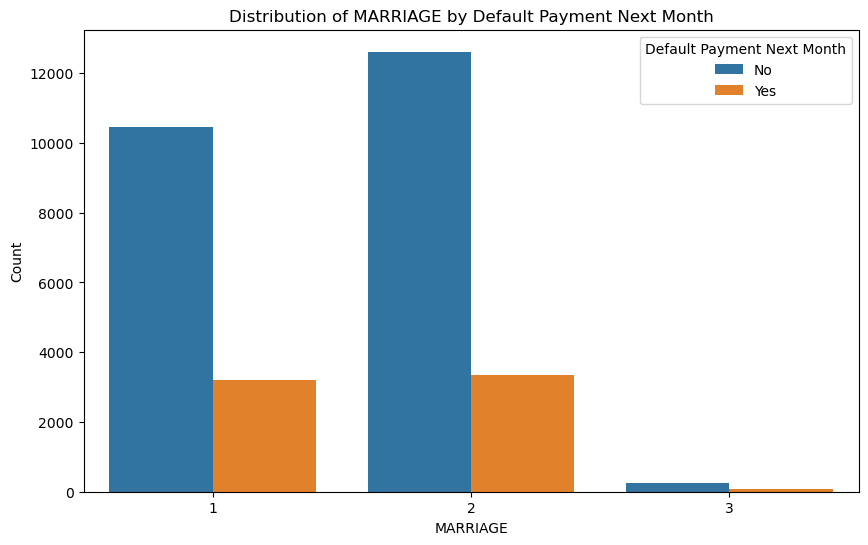

In [21]:

# Count plot for "MARRIAGE" by target variable
plt.figure(figsize=(10, 6))
sns.countplot(x="MARRIAGE", hue="default_payment_next_month", data=data_grouped.toPandas())
plt.title("Distribution of MARRIAGE by Default Payment Next Month")
plt.xlabel("MARRIAGE")
plt.ylabel("Count")
plt.legend(title="Default Payment Next Month", labels=["No", "Yes"])
plt.show()


From the above plot, we observed that Married Category has high probability to default the payment.

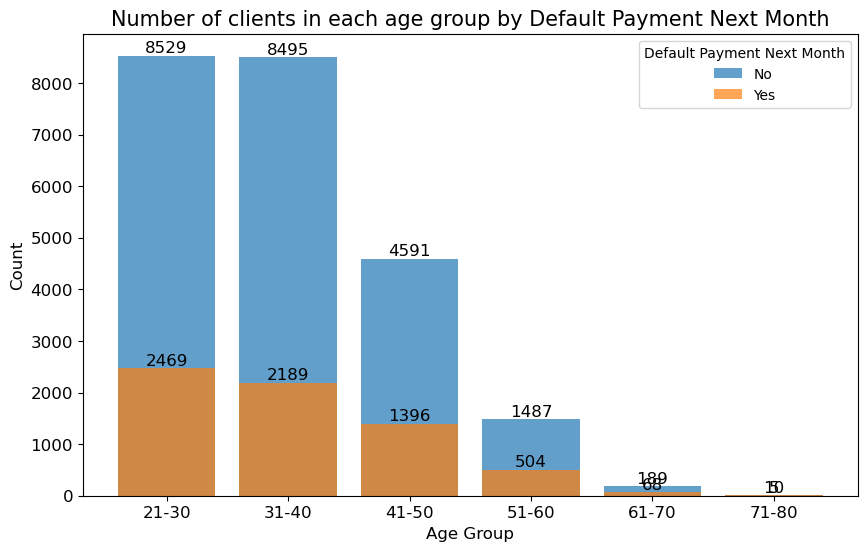

In [22]:
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt

# Define bins and labels
bins = [20, 30, 40, 50, 60, 70, 80]
names = ['21-30', '31-40', '41-50', '51-60', '61-70', '71-80']

# Create a new column 'AGE_BIN' in the PySpark DataFrame
data_grouped = data_grouped.withColumn(
    "AGE_BIN",
    when((col("AGE") >= 20) & (col("AGE") <= 30), "21-30")
    .when((col("AGE") > 30) & (col("AGE") <= 40), "31-40")
    .when((col("AGE") > 40) & (col("AGE") <= 50), "41-50")
    .when((col("AGE") > 50) & (col("AGE") <= 60), "51-60")
    .when((col("AGE") > 60) & (col("AGE") <= 70), "61-70")
    .when((col("AGE") > 70) & (col("AGE") <= 80), "71-80")
    .otherwise(None)
)

# Count the occurrences in each age group for both categories of "default_payment_next_month"
age_counts = data_grouped.groupBy("AGE_BIN", "default_payment_next_month").count().toPandas()

# Sort the DataFrame by age groups
age_counts = age_counts.sort_values(by="AGE_BIN")

# Plot the bar chart
plt.figure(figsize=(10, 6))
for label, df in age_counts.groupby("default_payment_next_month"):
    plt.bar(df["AGE_BIN"], df["count"], label=str(label), alpha=0.7)

# Annotate the bars with actual numbers
for x, y1, y0 in zip(names, age_counts[age_counts["default_payment_next_month"] == 1]["count"],
                      age_counts[age_counts["default_payment_next_month"] == 0]["count"]):
    plt.text(names.index(x), y1, str(y1), fontsize=12, ha='center', va='bottom')
    plt.text(names.index(x), y0, str(y0), fontsize=12, ha='center', va='bottom')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Number of clients in each age group by Default Payment Next Month", fontsize=15)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Default Payment Next Month", labels=["No", "Yes"])
plt.show()


The majority of clients fall within the 21-30 age group, followed by 31-40 age group. As the age group increases, the default on the payment next month decreases.

### FEATURE ENGINEERING

In [23]:
# Check the columns in the DataFrame
data_grouped.columns


['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default_payment_next_month',
 'EDUCATION_grouped',
 'AGE_BIN']

In [24]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Select all numerical columns as features
feature_columns = ["LIMIT_BAL", "SEX", "EDUCATION_grouped", "MARRIAGE", "AGE",
                    "PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
                    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
                    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]

# Create a VectorAssembler to combine selected features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create a StandardScaler to scale features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

# Define the stages of the pipeline
feature_engineering_pipeline = Pipeline(stages=[assembler, scaler])

# Fit and transform the data
data_transformed = feature_engineering_pipeline.fit(data_grouped).transform(data_grouped)


In [25]:
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Split the data into training and testing sets
train_data, test_data = data_transformed.randomSplit([0.8, 0.2], seed=42)

# Function to evaluate the model and print metrics
def evaluate_model(predictions):
    # Create a MulticlassClassificationEvaluator
    evaluator = MulticlassClassificationEvaluator(labelCol="default_payment_next_month", predictionCol="prediction", metricName="weightedPrecision")

    # Calculate evaluation metrics
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

    # Print evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

# Train Random Forest model
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="default_payment_next_month", seed=42)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Evaluate Random Forest model
print("Random Forest Model Evaluation:")
evaluate_model(rf_predictions)

# Train Decision Tree model
dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="default_payment_next_month", seed=42)
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# Evaluate Decision Tree model
print("\nDecision Tree Model Evaluation:")
evaluate_model(dt_predictions)

# Train Logistic Regression model
lr = LogisticRegression(featuresCol="scaled_features", labelCol="default_payment_next_month")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# Evaluate Logistic Regression model
print("\nLogistic Regression Model Evaluation:")
evaluate_model(lr_predictions)


Random Forest Model Evaluation:
Accuracy: 0.8258
Precision: 0.8098
Recall: 0.8258
F1 Score: 0.8018

Decision Tree Model Evaluation:
Accuracy: 0.8277
Precision: 0.8116
Recall: 0.8277
F1 Score: 0.8083

Logistic Regression Model Evaluation:
Accuracy: 0.8149
Precision: 0.7978
Recall: 0.8149
F1 Score: 0.7779


In [26]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
# Function to calculate Silhouette Score for different values of K
def evaluate_silhouette_score(data, kmeans_model):
    # Make predictions
    kmeans_predictions = kmeans_model.transform(data)
    # Evaluate Silhouette Score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(kmeans_predictions)
    # Print Silhouette Score
    print(f"Silhouette Score: {silhouette:.4f}")
# Train K-Means model outside the function
k_value_to_try = 2
kmeans = KMeans(featuresCol="scaled_features", k=k_value_to_try, seed=42)
kmeans_model = kmeans.fit(data_transformed)
# Call the function with the trained model
evaluate_silhouette_score(data_transformed, kmeans_model)

Silhouette Score: 0.7141


In [29]:
from pyspark.ml import PipelineModel

# Save Random Forest model
rf_model.write().overwrite().save("rf_model")

# # Save Decision Tree model
dt_model.write().overwrite().save("decision_tree_model")

# # Save Logistic Regression model
lr_model.write().overwrite().save("logistic_regression_model")

# Save Logistic Regression model
#kmeans__model.write().overwrite().save("Kmeans_model")

In [37]:
# !pip install cloudpickle

In [43]:
# import cloudpickle
# with open("saved_rf_model.pkl", "wb") as file:
#     cloudpickle.dump(rf_model, file)

In [44]:
# import joblib
# from pyspark.ml import PipelineModel

# #scikit_learn_model = rf_model.stages[-1]
# joblib.dump(rf_model, "saved__rf_model.joblib")
# #joblib.dump(scikit_learn_model, "C:/Users/rujjal.sada/Desktop/modified_project/models/saved__rf_model.joblib")